<a href="https://colab.research.google.com/github/BodaSadalla98/Deep_Learning_Notebooks/blob/main/AJGT_SA(not%20working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a try to do Sentiment Analysis task on AJGT dataset

## For now, there's something wrong and the model seeems to produce random weights and not actually learn

# This was inspired by  [here](https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/08.sentiment-analysis-with-bert.ipynb#scrollTo=1zhHoFNsxufs)

In [5]:
#Checking for GPU
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4
Sun Apr  4 10:33:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                            

In [6]:
!pip install transformers
!pip install farasapy
!pip install pyarabic
!pip install datasets

!git clone https://github.com/aub-mind/arabert

fatal: destination path 'arabert' already exists and is not an empty directory.


In [7]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader,Dataset
import torch.nn.functional as F
from collections import defaultdict


In [8]:
df = load_dataset("ajgt_twitter_ar")
df = pd.DataFrame(df['train'])

Reusing dataset ajgt_twitter_ar (/root/.cache/huggingface/datasets/ajgt_twitter_ar/plain_text/1.0.0/e113d014456168156a6ce74eb93efbeced96e60504762cf57a55024146860fa1)


In [9]:
%load_ext google.colab.data_table

In [10]:
df

,label,text
0,1,اربد فيها جامعات اكثر من عمان ... وفيها قد عم...
1,0,الحلو انكم بتحكوا على اساس انو الاردن ما فيه ...
2,1,كله رائع بجد ربنا يكرمك
3,0,لسانك قذر يا قمامه
4,0,​انا داشره وغير متزوجه ولدي علاقات مشبوه واحشش...
...,...,...
1795,0,يلعن شرف خواتك
1796,0,يلعنك نذل وكلب
1797,1,يمتاز الاردن بتنوع السياحه فيه فتنقسم السياحه ...
1798,1,ينور عليك ويكثر من امثالك


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


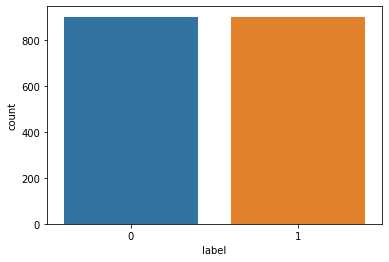

In [11]:
sns.countplot(df.label)

### Choosing Sequence Length

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


864
46.805


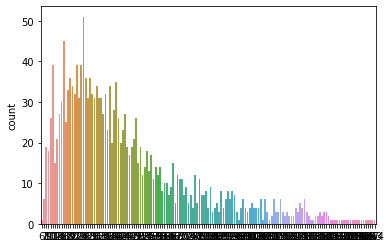

In [12]:
counts = []
ma = 0 
for sample in df.text:
  counts.append(len(sample))
  ma = max(ma,len(sample))

sns.countplot(counts)

print(max(counts))
print(sum(counts) / len(counts))

In [13]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModel,BertModel,AdamW, get_linear_schedule_with_warmup
from farasa.segmenter import FarasaSegmenter
from arabert.preprocess import ArabertPreprocessor
from sklearn.model_selection import train_test_split
import numpy as np
farasa_segmenter = FarasaSegmenter(interactive=True)
MODEL_NAME= 'aubmindlab/bert-base-arabertv2'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)



[2021-04-04 10:33:55,516 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


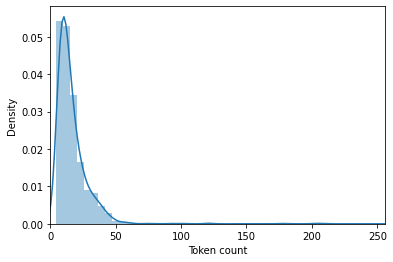

In [14]:
token_lens = []

for text in df.text:
  tokens = tokenizer.encode(text, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [15]:
sample_text = 'انا ف الللابوريا اه اه ايه, از از كابوريا اه اه ايه'

tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
farasa_text =  ArabertPreprocessor(MODEL_NAME).preprocess(sample_text)
farasa_tokenizer = tokens = tokenizer.tokenize(farasa_text)

print(f' Sentence: {sample_text}')
print(f'   Tokens: {tokens}')
print(f'  Farasa Tokens: {farasa_text}')

print(f'  Farasa Tokens: {farasa_tokenizer}')
print(f'Token IDs: {token_ids}')

[2021-04-04 10:34:00,420 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


 Sentence: انا ف الللابوريا اه اه ايه, از از كابوريا اه اه ايه
   Tokens: ['انا', 'ف', 'ال+', 'ابور', '##يا', 'اه', 'اه', 'اي', ',', 'از', 'از', 'كابوري', '+ا', 'اه', 'اه', 'اي']
  Farasa Tokens: أنا ف ال+ ابوريا اه اه أي , از از كابوري +ا اه اه أي
  Farasa Tokens: ['انا', 'ف', 'ال+', 'ابور', '##يا', 'اه', 'اه', 'اي', ',', 'از', 'از', 'كابوري', '+ا', 'اه', 'اه', 'اي']
Token IDs: [34670, 159, 2929, 44206, 7263, 1375, 1375, 909, 223, 46, 2446, 2446, 54758, 195, 1375, 1375, 909, 223]


In [16]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 64,
    add_special_tokens = True,
    return_token_type_ids= False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [17]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'انا',
 'ف',
 'الل',
 '##لاب',
 '##وريا',
 'اه',
 'اه',
 'اي',
 '##ه',
 ',',
 'از',
 'از',
 'كابوري',
 '##ا',
 'اه',
 'اه',
 'اي',
 '##ه',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [18]:
MAX_LEN = 128

In [19]:
class SADataset(Dataset):

  def __init__(self, sentences, labels, tokenizer, max_len):
    self.sentences = sentences
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.sentences)

  def __getitem__(self,item):
    sentence = str(self.sentences[item])
    label = self.labels[item]

    encoding = self.tokenizer.encode_plus(
      sentence,
      truncation=True,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      #pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
        'text':sentence,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label,dtype=torch.long)
    }


In [20]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=13)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=13)

In [21]:
print(df_train.shape , df_val.shape)

(1620, 2) (90, 2)


In [22]:
s  = SADataset(df.text,df.label,tokenizer=tokenizer,max_len=MAX_LEN)

print(s.__getitem__(10))

{'text': 'اتصور لو ظليت ما اتعلق احسن لانه تعليقاتك مقرفه', 'input_ids': tensor([   33, 59982,  1252,  1442,  6574,   331, 18806,   602, 28887,  2194,
          223,  2579, 14434, 41445,   223,    34,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31

In [23]:
def create_data_loader(df,tokenizer,batch_size,max_len):

  dataset = SADataset(
      df.text.to_numpy(),
      df.label.to_numpy(),
      tokenizer=tokenizer,
      max_len=MAX_LEN)
  

  return DataLoader(dataset=dataset,batch_size=batch_size,shuffle= True)



In [24]:
print(type(df_train.text))
print(type(df_train.text.to_numpy()))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [25]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train,tokenizer,BATCH_SIZE,MAX_LEN)
val_data_loader = create_data_loader(df_val,tokenizer,BATCH_SIZE,MAX_LEN)
test_data_loader = create_data_loader(df_test,tokenizer,BATCH_SIZE,MAX_LEN)

In [26]:
print(train_data_loader)

In [27]:

print(train_data_loader)
data = next(iter(train_data_loader))


print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)
print(data.keys())

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])
dict_keys(['text', 'input_ids', 'attention_mask', 'label'])


In [28]:


bert_model = BertModel.from_pretrained(MODEL_NAME)

o = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [29]:
print(type(o))
print(o.keys())
print(o.last_hidden_state.shape)
print(o.pooler_output.shape)
print(bert_model.config.hidden_size)

<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>
odict_keys(['last_hidden_state', 'pooler_output'])
torch.Size([1, 64, 768])
torch.Size([1, 768])
768


In [30]:
class SentimentClassifier(torch.nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier,self).__init__()
    self.n_classes = n_classes
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.out = torch.nn.Linear(self.bert.config.hidden_size, self.n_classes)

  def forward(self, input_ids, attention_mask):

    bert_output = self.bert(input_ids, attention_mask)

    return self.out(bert_output.pooler_output)


In [54]:
EPOCHS = 100



# we only have two classes 
model = SentimentClassifier(2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [55]:
def train_epoch(
    model,
    data_loader,
    loss_fn,
    device,
    scheduler,
    optimizer,
    n_examples
):
  model.train()

  losses = []
  correct_predictions = 0
  

  for batch in data_loader:
        

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    

    outputs = model (input_ids, attention_mask)


    _,preds = torch.max(outputs, dim=1)

    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

## Eval Function

In [56]:

def eval_model(
    model,
    data_loader,
    loss_fn,
    device,
    n_examples
):
  model.eval()

  losses = []
  correct_predictions = 0
  
  with torch.no_grad():
    for batch in data_loader:

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      outputs = model (input_ids, attention_mask)

      _,preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

## Train

In [57]:


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)


  train_acc, train_loss = train_epoch(
    model = model,
    data_loader = train_data_loader ,    
     loss_fn= loss_fn, 
    device = device,
    optimizer =optimizer, 
    scheduler = scheduler, 
    n_examples =len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    n_examples = len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/100
----------
Train loss 0.6208295226097107 accuracy 0.006790123456790123
Val   loss 1.1431635916233063 accuracy 0.5333333333333333

Epoch 2/100
----------
Train loss 0.9483651518821716 accuracy 0.0049382716049382715
Val   loss 3.3614577054977417 accuracy 0.4666666666666667

Epoch 3/100
----------
Train loss 3.837519645690918 accuracy 0.003703703703703704
Val   loss 2.293273150920868 accuracy 0.5333333333333333

Epoch 4/100
----------
Train loss 3.0330843925476074 accuracy 0.0049382716049382715
Val   loss 5.711143851280212 accuracy 0.4666666666666667

Epoch 5/100
----------
Train loss 3.204925060272217 accuracy 0.006790123456790123
Val   loss 1.017547110716502 accuracy 0.5333333333333333

Epoch 6/100
----------
Train loss 1.3076555728912354 accuracy 0.003703703703703704
Val   loss 2.7864777644475303 accuracy 0.4666666666666667

Epoch 7/100
----------
Train loss 1.9573783874511719 accuracy 0.006172839506172839
Val   loss 1.2177578806877136 accuracy 0.4666666666666667

Epoch 8/1

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### TESTING

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()